# Feature Selection & Scaling

@roman

11 Mar, 2024

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LassoCV, lasso_path
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import shap

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 500)
TODAY = pd.to_datetime('today')

---
# Lasso

## Read

In [3]:
# important columns
cols_to_stay = [
    'observation_id',
    'price',
    'half_bathrooms',
    'full_bathrooms',
    'age_in_months',
    'parking_lots',
    'valuation_date',
    'property_type_id',
    'elevator_service_id',
    'conservation_status_id',
    'level',
    'total_levels',
    'bedrooms',
    'built_area',
    'saleable_area',
    'land_area',
    'remaining_useful_life',
    'count_supermarkets_at_1km',
    'count_hospitals_at_5km',
    'count_metro_at_1km',
    'count_schools_at_1km',
    'count_restaurants_at_1km',
    'percep_ing',
    'ing_cor',
    'estim_alqu',
    'otros_ing',
    'gasto_mon',
    'vivienda',
    'alquiler',
    'pred_cons',
    'cuidados',
    'tenencia',
    'renta',
    'estim_pago',
    'pago_viv',
    'pago_mesp',
    'tipo_adqui',
    'tipo_finan',
    'total_viviendas',
    'ppsm_terrain'
]

# read database
df_properties = pd.read_parquet("../../data/clean/properties_shif.parquet").loc[:, cols_to_stay]

# set observation_id as index
df_properties = df_properties.set_index('observation_id')

# see
print(df_properties.shape)
df_properties.head(2)

(1908483, 39)


,price,half_bathrooms,full_bathrooms,age_in_months,parking_lots,valuation_date,property_type_id,elevator_service_id,conservation_status_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,tipo_finan,total_viviendas,ppsm_terrain
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
43c375b2-75fd-4fcc-b311-55b396e7cbbf,2349000,1,2,204,1,2022-11-15,2,0,4,3,2,3,141,154,198,53,2,3,0,0,19,2.210938,81674.453125,10253.206055,31.565142,47140.269531,3390.347168,1129.408691,295.455017,2439.210693,4,389.655090,3491.472412,512.813477,0.279052,1.0,1,294870,3740
f95c14fe-9acc-4b5c-872b-bd15d412a65d,424000,0,1,192,1,2022-11-01,2,2,4,3,1,2,52,54,133,44,0,0,0,0,0,2.564453,54447.476562,4833.395996,3.735561,37908.296875,1927.791382,391.177155,157.040634,1460.746460,4,133.639404,1646.661743,567.759888,0.311107,1.0,1,34959,886


## Wrangling

### NaNs

In [4]:
# nan values
df_properties.isna().mean()[df_properties.isna().mean().gt(0)]

Series([], dtype: float64)

### Casting

In [5]:
# cast to string
cols_categorical = list(set(
    df_properties.select_dtypes(include='string').columns.tolist()
    + df_properties.select_dtypes(include='category').columns.tolist() 
    + df_properties.select_dtypes(include='object').columns.tolist()
    + df_properties.filter(like='_id').columns.tolist()
    ))

# to categorical
df_properties[cols_categorical] = df_properties[cols_categorical].astype('category')

## Feature Engineering

In [6]:
# params
first_date_obs = df_properties['valuation_date'].min()
last_date_obs = df_properties['valuation_date'].max()

# create columns
df_properties = (
    df_properties
    .assign(
        # objective variable
        ppsm=lambda x: x['price'] / x['saleable_area'],
        # quarters since appraisal
        quarters_since_first_appraisal=lambda x: (x['valuation_date'] - first_date_obs).dt.days / (30.4 * 3),
        # recategorizations
        has_elevator=lambda x: np.where(x['elevator_service_id'].eq(1), 1, 0),
        is_new=lambda x: x['age_in_months'].le(1).astype(int),
        conservacion_recat=lambda x: x['conservation_status_id'].replace({7: 3.5}).astype(int),
    )
)

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_3483/1260834000.py:16: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  conservacion_recat=lambda x: x['conservation_status_id'].replace({7: 3.5}).astype(int),


In [7]:
# count of unique values 
def count_unique_values(df, col, max_values=10):
    """
    Count the number of unique values in a column and return the result as a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        col (str): The column to analyze.
        max_values (int): The maximum number of unique values to display. If there are more unique values, they will be grouped in an 'Others' category.
    
    Returns:
        pd.DataFrame: A DataFrame with the count of unique values.
    """
    # counts
    table_counts = (
        df[col]
        .value_counts(dropna=False)
        .reset_index()
        .assign(
            perc=lambda x: x['count'] / x['count'].sum()
        )
        .sort_values(by='count', ascending=False)
        .head(max_values)
    )
    
    num_others = df.shape[0] - table_counts['count'].sum()

    # append others if necessary
    if num_others > 0:
        table_counts = pd.concat([
            table_counts,
            pd.DataFrame({
                col: 'others',
                'count': [num_others],
                'perc': [num_others / df.shape[0]]
            })
        ],
        axis=0,
        ignore_index=True
    )

    return table_counts

# counts of categorical columns
cols_to_count = df_properties.select_dtypes(include='category').columns.tolist()
for col in cols_to_count:
    print(f"\n{col} {'=' * 50}")
    print(count_unique_values(df_properties, col, 10))


property_type_id ==================================================
  property_type_id   count      perc
0                2  958391  0.502174
1                3  529873  0.277641
2                4  420219  0.220185

elevator_service_id ==================================================
  elevator_service_id    count      perc
0                   2  1407355  0.737421
1                   0   460853  0.241476
2                   1    40275  0.021103

conservation_status_id ==================================================
  conservation_status_id   count      perc
0                      6  910747  0.477210
1                      4  870514  0.456129
2                      5   87763  0.045986
3                      7   35335  0.018515
4                      3    4124  0.002161


In [8]:
# see new var
df_properties.describe()

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,price,half_bathrooms,full_bathrooms,age_in_months,parking_lots,valuation_date,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,tipo_finan,total_viviendas,ppsm_terrain,ppsm,quarters_since_first_appraisal,has_elevator,is_new,conservacion_recat
count,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1908483,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06
mean,1.483767e+06,3.491700e-01,1.488231e+00,5.291538e+01,1.135525e+00,2021-06-26 07:39:58.221204736,3.443452e+00,1.592710e+00,2.356046e+00,8.559633e+01,9.101616e+01,1.116373e+02,5.870005e+01,7.675478e-01,2.313320e+00,3.605010e-02,6.813841e-02,1.583942e+00,NaN,6.397008e+04,7.525788e+03,5.501279e+01,3.862198e+04,4.140751e+03,1.615227e+03,2.820286e+02,1.754710e+03,3.855138e+00,5.531334e+02,2.563890e+03,5.042402e+02,3.304807e-01,1.311779e+00,3.439830e+00,1.745507e+05,4.893699e+03,1.479020e+04,9.948678e+00,2.110315e-02,4.691349e-01,4.979730e+00
min,2.000000e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2019-01-01 00:00:00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+01,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.307617e+00,1.846488e+04,2.322577e+03,0.000000e+00,1.298909e+04,5.410000e+02,0.000000e+00,0.000000e+00,3.696533e+02,1.000000e+00,0.000000e+00,8.000000e+02,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,8.800000e+02,1.590000e+02,4.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,5.450000e+05,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2020-03-17 00:00:00,3.000000e+00,1.000000e+00,2.000000e+00,4.900000e+01,5.000000e+01,6.400000e+01,5.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.101562e+00,5.190688e+04,5.304737e+03,4.028208e+00,3.170567e+04,2.947570e+03,7.516017e+02,1.184212e+02,1.403711e+03,4.000000e+00,2.522204e+02,1.809421e+03,2.551812e+02,2.445493e-01,1.000000e+00,1.000000e+00,6.246800e+04,1.973000e+03,9.883721e+03,4.835526e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,8.250000e+05,0.000000e+00,1.000000e+00,8.000000e+00,1.000000e+00,2021-05-27 00:00:00,3.000000e+00,1.000000e+00,2.000000e+00,6.500000e+01,6.600000e+01,9.400000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.226562e+00,6.091250e+04,6.798937e+03,3.389166e+01,3.695386e+04,3.741147e+03,1.204490e+03,2.078829e+02,1.633519e+03,4.000000e+00,4.084537e+02,2.315394e+03,4.774912e+02,3.241348e-01,1.000000e+00,5.000000e+00,1.555330e+05,2.708000e+03,1.214286e+04,9.616228e+00,0.000000e+00,0.000000e+00,5.000000e+00
75%,1.626000e+06,1.000000e+00,2.000000e+00,9.600000e+01,1.000000e+00,2022-10-24 00:00:00,3.000000e+00,2.000000e+00,3.000000e+00,1.010000e+02,1.060000e+02,1.240000e+02,7.000000e+01,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.322266e+00,7.242860e+04,8.810545e+03,6.920169e+01,4.398474e+04,4.658048e+03,1.766107e+03,3.447090e+02,1.957372e+03,4.000000e+00,6.054603e+02,3.000441e+03,7.008428e+02,4.039700e-01,1.000000e+00,5.000000e+00,2.609910e+05,4.222000e+03,1.592593e+04,1.526316e+01,0.000000e+00,1.000000e+00,6.000000e+00
max,8.958900e+07,6.000000e+00,8.000000e+00,2.550000e+02,8.000000e+00,2023-12-31 00:00:00,3.300000e+01,5.700000e+01,6.000000e+00,1.556000e+03,1.973000e+03,9.944000e+03,8.000000e+01,1.000000e+01,4.100000e+01,1.

## Drop

In [9]:
# cols 2 drop
cols2drop = [
    'price',
    'valuation_date',
    'elevator_service_id',
    'conservation_status_id'
]

# drop cols
df_properties = df_properties.drop(columns=cols2drop)

## Scaling

In [10]:
# scaling
df_properties = (
    df_properties
    .assign(
        # surfaces
        saleable_area=lambda x: np.log(x['saleable_area']),
        land_area=lambda x: np.log1p(x['land_area']),
        # counts
        count_supermarkets_at_1km=lambda x: np.sqrt(x['count_supermarkets_at_1km']),
        count_hospitals_at_5km=lambda x: np.sqrt(x['count_hospitals_at_5km']),
        count_metro_at_1km=lambda x: np.sqrt(x['count_metro_at_1km']),
        count_schools_at_1km=lambda x: np.sqrt(x['count_schools_at_1km']),
        count_restaurants_at_1km=lambda x: np.sqrt(x['count_restaurants_at_1km']),
        # ing
        ing_cor=lambda x: np.log(x['ing_cor']),
        # terrain
        ppsm_terrain=lambda x: np.log(x['ppsm_terrain']),
        # objective variable
        log_price_per_sqm=lambda x: np.log(x['ppsm']),
    )
)

# drop ppsm
df_properties = df_properties.drop(columns=['ppsm'])

In [11]:
# standardize all numeric columns
scaler = StandardScaler()

# see numeric columns
cols_numeric = df_properties.select_dtypes(include='number').columns.tolist()

# remove has_elevator and is_new
cols_numeric.remove('has_elevator')
cols_numeric.remove('is_new')

# fit and transform
df_properties[cols_numeric] = scaler.fit_transform(df_properties[cols_numeric])

# see
df_properties[cols_numeric].describe()

,half_bathrooms,full_bathrooms,age_in_months,parking_lots,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,tipo_finan,total_viviendas,ppsm_terrain,quarters_since_first_appraisal,conservacion_recat,log_price_per_sqm
count,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06
mean,-6.385820e-17,9.685955e-17,-6.195199e-18,3.026116e-17,-9.292798e-18,-1.822818e-17,2.823581e-16,-6.862374e-17,-4.979987e-16,7.958447e-16,-2.173085e-16,-4.560024e-17,8.935383e-19,6.469217e-17,1.457957e-17,-1.033824e-16,-2.289841e-16,2.246296e-15,1.322437e-17,-6.149777e-16,-1.953870e-16,1.130922e-16,7.910792e-17,3.580110e-17,-1.744782e-16,2.435190e-16,3.532455e-17,-4.926374e-17,-7.380626e-17,9.814028e-17,5.405906e-17,-1.661981e-17,-1.219680e-17,7.496726e-15,-1.323747e-15,-4.527260e-17,-1.913363e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.813315e-01,-6.064980e-01,-7.202727e-01,-1.722303e+00,-1.941220e+00,-1.459475e+00,-1.980262e+00,-1.072634e+00,-1.714746e+00,-6.943212e+00,-5.194149e+00,-8.082935e-01,-8.332726e-01,-1.403257e-01,-2.247284e-01,-3.722422e-01,-4.672307e+00,-4.264696e+00,-1.498558e+00,-6.353044e-01,-2.219480e+00,-1.619951e+00,-9.172376e-01,-8.213540e-01,-1.948747e+00,-5.308555e+00,-9.117368e-01,-1.492475e+00,-1.488111e+00,-2.376208e+00,-5.221128e-01,-1.765869e+00,-1.332098e+00,-3.904292e+00,-1.690750e+00,-1.964437e+00,-2.688172e+00
25%,-6.813315e-01,-6.064980e-01,-7.202727e-01,-2.055569e-01,-2.499928e-01,-5.431279e-01,-5.199415e-01,-5.984245e-01,-7.763967e-01,-5.155275e-01,-5.928622e-01,-8.082935e-01,-8.332726e-01,-1.403257e-01,-2.247284e-01,-3.722422e-01,-6.190538e-01,-5.943772e-01,-6.396772e-01,-5.887854e-01,-5.988643e-01,-5.369528e-01,-4.904262e-01,-4.764751e-01,-4.938497e-01,2.693411e-01,-4.959986e-01,-6.383772e-01,-7.350218e-01,-6.178600e-01,-5.221128e-01,-1.252510e+00,-8.597022e-01,-6.185253e-01,-8.689660e-01,-9.721619e-01,-6.443756e-01
50%,-6.813315e-01,-6.064980e-01,-6.113784e-01,-2.055569e-01,-2.499928e-01,-5.431279e-01,-5.199415e-01,-3.367919e-01,-2.664075e-01,6.880728e-02,1.150281e-01,-8.082935e-01,2.250487e-02,-1.403257e-01,-2.247284e-01,-3.722422e-01,1.909678e-02,-2.624994e-02,-2.093385e-01,-2.439133e-01,-1.444388e-01,-1.798295e-01,-2.332447e-01,-2.159352e-01,-1.705143e-01,2.693411e-01,-2.384773e-01,-2.102598e-01,-7.894165e-02,-4.562718e-02,-5.221128e-01,8.009277e-01,-1.458705e-01,-2.053852e-01,-5.649893e-02,2.011345e-02,-1.792837e-01
75%,1.269957e+00,6.357372e-01,5.864586e-01,-2.055569e-01,-2.499928e-01,3.732188e-01,9.403791e-01,2.518814e-01,6.038998e-01,4.913827e-01,9.998909e-01,6.593502e-01,3.768502e-01,-1.403257e-01,-2.247284e-01,-3.722422e-01,5.076808e-01,5.886628e-01,3.700172e-01,1.638576e-01,4.643459e-01,2.327918e-01,8.568003e-02,1.825445e-01,2.851399e-01,2.693411e-01,8.625134e-02,3.693775e-01,5.802126e-01,5.284007e-01,-5.221128e-01,8.009277e-01,6.630187e-01,3.740305e-01,9.03

## One hot encoding

todo: subset only the most important features and elimnate the rest (redundant for the recats)

In [12]:
# look for categorical columns
df_properties.select_dtypes(include='category').columns.tolist()

['property_type_id']

In [13]:
# one hot encoding
columns_to_one_hot = [
    'property_type_id'
]

# one hot encoding
df_properties = pd.get_dummies(df_properties, columns=columns_to_one_hot, drop_first=True, dtype='int')

# see columns
df_properties.columns

Index(['half_bathrooms', 'full_bathrooms', 'age_in_months', 'parking_lots',
       'level', 'total_levels', 'bedrooms', 'built_area', 'saleable_area',
       'land_area', 'remaining_useful_life', 'count_supermarkets_at_1km',
       'count_hospitals_at_5km', 'count_metro_at_1km', 'count_schools_at_1km',
       'count_restaurants_at_1km', 'percep_ing', 'ing_cor', 'estim_alqu',
       'otros_ing', 'gasto_mon', 'vivienda', 'alquiler', 'pred_cons',
       'cuidados', 'tenencia', 'renta', 'estim_pago', 'pago_viv', 'pago_mesp',
       'tipo_adqui', 'tipo_finan', 'total_viviendas', 'ppsm_terrain',
       'quarters_since_first_appraisal', 'has_elevator', 'is_new',
       'conservacion_recat', 'log_price_per_sqm', 'property_type_id_3',
       'property_type_id_4'],
      dtype='object')

## Split Data

In [14]:
# get important columns
X = df_properties.drop(columns='log_price_per_sqm').copy()
y = df_properties['log_price_per_sqm'].copy()

In [15]:
# remove df and X
del df_properties

## Fit Lasso

In [16]:
def visualize_beta_decay(X, y, n_alphas=100, n_highlight=5, scale=True):
    """
    Visualize how betas decay as alpha increases using lasso_path.
    Highlights top performing features by their index.
    Uses gray for non-highlighted features and adds a black line at y=0.
    """ 
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        alphas, coefs, _ = lasso_path(X_scaled, y, n_alphas=n_alphas)
    else:
        alphas, coefs, _ = lasso_path(X, y, n_alphas=n_alphas)
    
    # Convert coefficients to a DataFrame for easier manipulation
    coef_df = pd.DataFrame(coefs.T, columns=[f"Feature {i}" for i in range(coefs.shape[0])])
    coef_df.index = alphas

    # Plot
    _, ax = plt.subplots(figsize=(8, 6))
    
    alpha_min = coef_df.index.min()
    top_coefs = coef_df.loc[alpha_min].map(abs).sort_values().tail(n_highlight)
    
    # Plot non-highlighted features in gray
    for feature in coef_df.columns:
        if feature not in top_coefs.index:
            ax.semilogx(coef_df.index, coef_df[feature], "-", color='gray', alpha=0.5)
    
    # Plot highlighted features in color
    for feature in top_coefs.index:
        ax.semilogx(coef_df.index, coef_df[feature], "-", label=feature)
        feature_index = int(feature.split()[-1])  # Extract feature index
        plt.text(
            alpha_min, 
            coef_df.loc[alpha_min, feature],
            f"f.{feature_index}", 
            horizontalalignment="right", 
            verticalalignment="center"
        )

    # Add black horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    # Format plot
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Coefficient")
    ax.set_title("Beta Decay with Increasing Alpha (using lasso_path)")
    plt.tight_layout()
    plt.show()

    # print the name of the features (number, name)
    for feature in top_coefs.index:
        feature_index = int(feature.split()[-1])  # Extract feature index
        print(f"f.{feature_index}: {X.columns[feature_index]}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


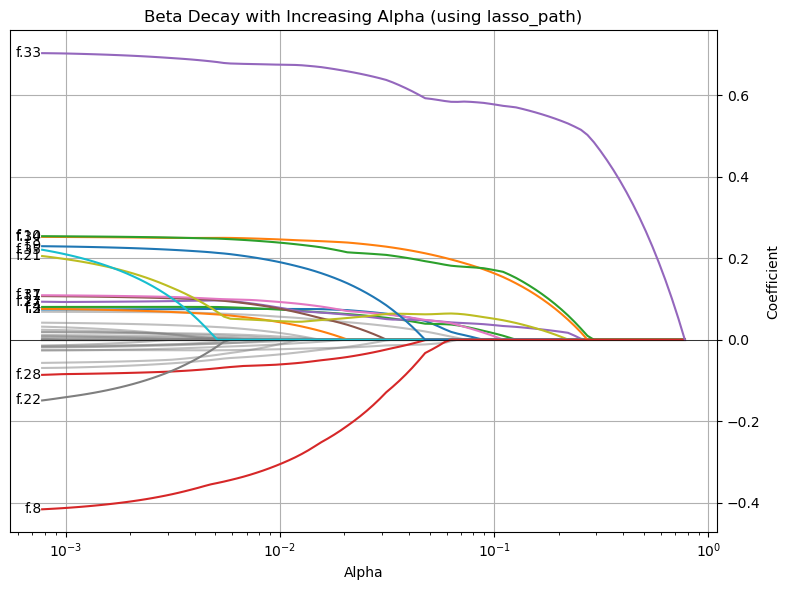

f.3: parking_lots
f.2: age_in_months
f.4: level
f.28: pago_viv
f.27: estim_pago
f.1: full_bathrooms
f.37: conservacion_recat
f.22: alquiler
f.21: vivienda
f.35: has_elevator
f.9: land_area
f.34: quarters_since_first_appraisal
f.10: remaining_useful_life
f.8: saleable_area
f.33: ppsm_terrain


In [18]:
# visualize scaled
visualize_beta_decay(X, y, n_highlight=15, scale=False, n_alphas=100)

notes:
- search for models that can predict if the property is a house or a department (i guess it will be easy)

In [ ]:
# delete X
del X, y

---
# Catboost

## Read

In [3]:
# important columns
cols_to_stay = [
    'observation_id',
    'price',
    'half_bathrooms',
    'full_bathrooms',
    'age_in_months',
    'parking_lots',
    'valuation_date',
    'potable_water_service_id',
    'lighting_service_id',
    'sidewalk_id',
    'conservation_status_id',
    'elevator_service_id',
    'equipment_id',
    'road_materials_id',
    'urban_proximity_id',
    'electrical_supply_service_id',
    'telephone_service_supply_id',
    'property_type_id',
    'level',
    'total_levels',
    'bedrooms',
    'built_area',
    'saleable_area',
    'land_area',
    'remaining_useful_life',
    'distance_to_ocean',
    'ocean_label',
    'count_supermarkets_at_1km',
    'count_hospitals_at_5km',
    'count_metro_at_1km',
    'count_schools_at_1km',
    'count_restaurants_at_1km',
    'est_socio',
    'educa_jefe',
    'tot_integ',
    'p12_64',
    'p65mas',
    'percep_ing',
    'ing_cor',
    'estim_alqu',
    'otros_ing',
    'gasto_mon',
    'vivienda',
    'alquiler',
    'pred_cons',
    'cuidados',
    'antiguedad',
    'cuart_dorm',
    'tenencia',
    'renta',
    'estim_pago',
    'pago_viv',
    'pago_mesp',
    'tipo_adqui',
    'viv_usada',
    'tipo_finan',
    'total_viviendas',
    'ppsm_terrain'
 ]

# read database
df_properties = pd.read_parquet("../../data/clean/properties_shif.parquet").loc[:, cols_to_stay]

# set observation_id as index
df_properties = df_properties.set_index('observation_id')

# see
print(df_properties.shape)
df_properties.head(2)

(1908483, 57)


,price,half_bathrooms,full_bathrooms,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,conservation_status_id,elevator_service_id,equipment_id,road_materials_id,urban_proximity_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,distance_to_ocean,ocean_label,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,est_socio,educa_jefe,tot_integ,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,total_viviendas,ppsm_terrain
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
43c375b2-75fd-4fcc-b311-55b396e7cbbf,2349000,1,2,204,1,2022-11-15,0,0,0,4,0,2,2,2,0,0,2,3,2,3,141,154,198,53,50000,golfo_de_mexico,2,3,0,0,19,2.724609,7.06250,3.197266,2.367188,0.373291,2.210938,81674.453125,10253.206055,31.565142,47140.269531,3390.347168,1129.408691,295.455017,2439.210693,24.31250,2.015625,4,389.655090,3491.472412,512.813477,0.279052,1.0,0.174438,1,294870,3740
f95c14fe-9acc-4b5c-872b-bd15d412a65d,424000,0,1,192,1,2022-11-01,0,0,0,4,2,2,3,3,0,0,2,3,1,2,52,54,133,44,50000,golfo_de_mexico,0,0,0,0,0,1.929688,5.65625,4.042969,2.964844,0.262451,2.564453,54447.476562,4833.395996,3.735561,37908.296875,1927.791382,391.177155,157.040634,1460.746460,17.65625,1.934570,4,133.639404,1646.661743,567.759888,0.311107,1.0,0.101379,1,34959,886


## Wrangling

### NaNs

In [4]:
# nan values
df_properties.isna().mean()[df_properties.isna().mean().gt(0)]

Series([], dtype: float64)

### Casting

In [5]:
# mapping
mappers = {
    'equipment_id': {
        1: 'low',
        2: 'medium',
        3: 'high',
        4: 'perfect',
    },
    'potable_water_service_id': {
        0: 'does_not_apply',
        1: 'exists',
        2: 'not_exist',
        3: 'not_exist',
    },
    'elevator_service_id': {
        0: 'does_not_apply',
        1: 'exists',
        2: 'not_exist',
    },
    'lighting_service_id': {
        0: 'does_not_apply',
        1: 'a',
        2: 'b',
        3: 'c',
    },
    'road_materials_id': {
        0: 'does_not_apply',
        1: 'terrace',
        2: 'asphalt',
        3: 'concrete',
        4: 'cobblestone',
        5: 'paver',
        6: 'other',
        7: 'not_exist',
        8: 'permeable_pavement',
    },
    'urban_proximity_id': {
        1: 'centric',
        2: 'intermediate',
        3: 'peripheral',
        4: 'expansion',
        5: 'rural',
    },
    # doubt: does a apartment implies a condominium?
    'property_type_id': {
        2: 'house',
        3: 'house_on_condominium',
        4: 'apartment',
    },
    'telephone_service_supply_id': {
        0: 'does_not_apply',
        1: 'aerial',
        2: 'underground',
        3: 'not_exist',
        4: 'not_exist',
        5: 'not_exist',
    },
    'sidewalk_id': {
        0: 'does_not_apply',
        1: 'concrete',
        2: 'paver',
        3: 'cobblestone',
        4: 'other',
        5: 'not_exist',
    },
    'electrical_supply_service_id': {
        0: 'does_not_apply',
        1: 'with_suminister',
        2: 'without_suminister',
        3: 'other',
    }
}

# map
df_properties = df_properties.replace(mappers)


In [6]:
# cast to string
cols_categorical = list(set(
    df_properties.select_dtypes(include='string').columns.tolist()
    + df_properties.select_dtypes(include='category').columns.tolist() 
    + df_properties.select_dtypes(include='object').columns.tolist()
    ))

# to categorical
print(cols_categorical)
df_properties[cols_categorical] = df_properties[cols_categorical].astype('category')

['telephone_service_supply_id', 'road_materials_id', 'property_type_id', 'equipment_id', 'elevator_service_id', 'urban_proximity_id', 'sidewalk_id', 'lighting_service_id', 'ocean_label', 'electrical_supply_service_id', 'potable_water_service_id']


## Feature Engineering

In [7]:
# params
first_date_obs = df_properties['valuation_date'].min()
last_date_obs = df_properties['valuation_date'].max()

# create columns
df_properties = (
    df_properties
    .assign(
        # objective variable
        ppsm=lambda x: x['price'] / x['saleable_area'],
        # quarters since appraisal
        quarters_since_first_appraisal=lambda x: (x['valuation_date'] - first_date_obs).dt.days / (30.4 * 3),
        is_new=lambda x: np.where(x['age_in_months'].le(1), 'new', 'used'),
        conservacion_recat=lambda x: x['conservation_status_id'].replace({7: 3.5}).astype(int),
    )
    .assign(
        is_new=lambda x: x['is_new'].astype('category'),
    )
)

## Categorical Variables

In [8]:
# count of unique values 
def count_unique_values(df, col, max_values=10):
    """
    Count the number of unique values in a column and return the result as a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        col (str): The column to analyze.
        max_values (int): The maximum number of unique values to display. If there are more unique values, they will be grouped in an 'Others' category.
    
    Returns:
        pd.DataFrame: A DataFrame with the count of unique values.
    """
    # counts
    table_counts = (
        df[col]
        .value_counts(dropna=False)
        .reset_index()
        .assign(
            perc=lambda x: x['count'] / x['count'].sum()
        )
        .sort_values(by='count', ascending=False)
        .head(max_values)
    )
    
    num_others = df.shape[0] - table_counts['count'].sum()

    # append others if necessary
    if num_others > 0:
        table_counts = pd.concat([
            table_counts,
            pd.DataFrame({
                col: 'others',
                'count': [num_others],
                'perc': [num_others / df.shape[0]]
            })
        ],
        axis=0,
        ignore_index=True
    )

    return table_counts

# counts of categorical columns
cols_to_count = df_properties.select_dtypes(include='category').columns.tolist()
for col in cols_to_count:
    print(f"\n{col} {'=' * 50}")
    print(count_unique_values(df_properties, col, 10))


potable_water_service_id ==================================================
  potable_water_service_id    count      perc
0                   exists  1272946  0.666994
1           does_not_apply   632671  0.331505
2                not_exist     2866  0.001502

lighting_service_id ==================================================
  lighting_service_id   count      perc
0                   c  761388  0.398949
1      does_not_apply  632703  0.331521
2                   b  512425  0.268499
3                   a    1967  0.001031

sidewalk_id ==================================================
      sidewalk_id    count      perc
0        concrete  1228728  0.643824
1  does_not_apply   634363  0.332391
2       not_exist    24912  0.013053
3           other    11234  0.005886
4     cobblestone     8081  0.004234
5           paver     1165  0.000610

elevator_service_id ==================================================
  elevator_service_id    count      perc
0           not_exist  1407355 

In [9]:
# see new var
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1908483 entries, 43c375b2-75fd-4fcc-b311-55b396e7cbbf to e59c0988-c457-465f-8659-3be40e35ce58
Data columns (total 61 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   price                           uint32        
 1   half_bathrooms                  uint8         
 2   full_bathrooms                  uint8         
 3   age_in_months                   uint8         
 4   parking_lots                    uint8         
 5   valuation_date                  datetime64[ns]
 6   potable_water_service_id        category      
 7   lighting_service_id             category      
 8   sidewalk_id                     category      
 9   conservation_status_id          uint8         
 10  elevator_service_id             category      
 11  equipment_id                    category      
 12  road_materials_id               category      
 13  urban_proximity_id              category   

## Scaling

In [10]:
df_properties.select_dtypes(include='number').columns.tolist()

['price',
 'half_bathrooms',
 'full_bathrooms',
 'age_in_months',
 'parking_lots',
 'conservation_status_id',
 'level',
 'total_levels',
 'bedrooms',
 'built_area',
 'saleable_area',
 'land_area',
 'remaining_useful_life',
 'distance_to_ocean',
 'count_supermarkets_at_1km',
 'count_hospitals_at_5km',
 'count_metro_at_1km',
 'count_schools_at_1km',
 'count_restaurants_at_1km',
 'est_socio',
 'educa_jefe',
 'tot_integ',
 'p12_64',
 'p65mas',
 'percep_ing',
 'ing_cor',
 'estim_alqu',
 'otros_ing',
 'gasto_mon',
 'vivienda',
 'alquiler',
 'pred_cons',
 'cuidados',
 'antiguedad',
 'cuart_dorm',
 'tenencia',
 'renta',
 'estim_pago',
 'pago_viv',
 'pago_mesp',
 'tipo_adqui',
 'viv_usada',
 'tipo_finan',
 'total_viviendas',
 'ppsm_terrain',
 'ppsm',
 'quarters_since_first_appraisal',
 'conservacion_recat']

In [12]:
# standardize all numeric columns
scaler = StandardScaler()

# see numeric columns
cols_numeric = df_properties.select_dtypes(include='number').columns.tolist()
cols_numeric.remove('price')

# fit and transform
df_properties[cols_numeric] = scaler.fit_transform(df_properties[cols_numeric])

# see
df_properties[cols_numeric].describe()

,half_bathrooms,full_bathrooms,age_in_months,parking_lots,conservation_status_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,distance_to_ocean,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,est_socio,educa_jefe,tot_integ,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,total_viviendas,ppsm_terrain,ppsm,quarters_since_first_appraisal,conservacion_recat
count,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06,1.908483e+06
mean,-6.385820e-17,9.685955e-17,-6.195199e-18,3.026116e-17,-4.987135e-16,-9.292798e-18,-1.822818e-17,2.823581e-16,-6.862374e-17,1.524972e-17,1.572627e-17,-2.173085e-16,-9.069413e-18,7.252552e-17,2.738695e-17,-5.242091e-18,-9.188552e-18,-1.201809e-17,-3.441314e-16,2.501014e-16,-5.301660e-16,8.621751e-16,-1.756398e-16,-2.289841e-16,-9.971887e-17,1.322437e-17,-6.149777e-16,-1.953870e-16,1.130922e-16,7.910792e-17,3.580110e-17,-1.744782e-16,3.755839e-17,-1.521249e-16,2.435190e-16,3.532455e-17,-4.926374e-17,-7.380626e-17,9.814028e-17,5.405906e-17,5.265919e-17,-1.661981e-17,-1.219680e-17,-4.294941e-17,6.950536e-16,-1.323747e-15,-4.527260e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.813315e-01,-6.064980e-01,-7.202727e-01,-1.722303e+00,-2.040419e+00,-1.941220e+00,-1.459475e+00,-1.980262e+00,-1.072634e+00,-8.670646e-01,-1.041792e+00,-5.194149e+00,-2.684338e+00,-6.666124e-01,-4.634617e-01,-1.251821e-01,-1.939405e-01,-1.967855e-01,-3.787313e+00,-4.983751e+00,-4.425543e+00,-4.915148e+00,-2.617441e+00,-4.672307e+00,-2.162966e+00,-1.498558e+00,-6.353044e-01,-2.219480e+00,-1.619951e+00,-9.172376e-01,-8.213540e-01,-1.948747e+00,-3.088137e+00,-4.582776e+00,-5.308555e+00,-9.117368e-01,-1.492475e+00,-1.488111e+00,-2.376208e+00,-5.221128e-01,-1.979662e+00,-1.765869e+00,-1.332098e+00,-5.758438e-01,-1.157437e+00,-1.690750e+00,-1.964437e+00
25%,-6.813315e-01,-6.064980e-01,-7.202727e-01,-2.055569e-01,-1.046929e+00,-2.499928e-01,-5.431279e-01,-5.199415e-01,-5.984245e-01,-5.828564e-01,-4.445480e-01,-5.928622e-01,4.991897e-01,-6.666124e-01,-4.634617e-01,-1.251821e-01,-1.939405e-01,-1.967855e-01,-5.506775e-01,-5.194747e-01,-5.637459e-01,-5.771446e-01,-6.640855e-01,-6.190538e-01,-5.733917e-01,-6.396772e-01,-5.887854e-01,-5.988643e-01,-5.369528e-01,-4.904262e-01,-4.764751e-01,-4.938497e-01,-6.082852e-01,-6.728524e-01,2.693411e-01,-4.959986e-01,-6.383772e-01,-7.350218e-01,-6.178600e-01,-5.221128e-01,-6.854776e-01,-1.252510e+00,-8.597022e-01,-3.552214e-01,-5.263053e-01,-8.689660e-01,-9.721619e-01
50%,-6.813315e-01,-6.064980e-01,-6.113784e-01,-2.055569e-01,-5.343864e-02,-2.499928e-01,-5.431279e-01,-5.199415e-01,-3.367919e-01,-3.554899e-01,-1.645900e-01,1.150281e-01,4.991897e-01,-6.666

## Split Data

In [13]:
# get important columns
X = df_properties.drop(columns=['ppsm', 'price', 'valuation_date']).copy()
y = df_properties['ppsm'].copy()

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=X['property_type_id']
    )

In [14]:
# delete
del X, y, df_properties

In [15]:
# pool
cols_categorical = X_train.select_dtypes(include='category').columns.tolist()

train_pool = Pool(X_train, y_train, cat_features=cols_categorical)
test_pool = Pool(X_test, y_test, cat_features=cols_categorical)

## Fit Catboost

In [16]:
X_train.columns

Index(['half_bathrooms', 'full_bathrooms', 'age_in_months', 'parking_lots',
       'potable_water_service_id', 'lighting_service_id', 'sidewalk_id',
       'conservation_status_id', 'elevator_service_id', 'equipment_id',
       'road_materials_id', 'urban_proximity_id',
       'electrical_supply_service_id', 'telephone_service_supply_id',
       'property_type_id', 'level', 'total_levels', 'bedrooms', 'built_area',
       'saleable_area', 'land_area', 'remaining_useful_life',
       'distance_to_ocean', 'ocean_label', 'count_supermarkets_at_1km',
       'count_hospitals_at_5km', 'count_metro_at_1km', 'count_schools_at_1km',
       'count_restaurants_at_1km', 'est_socio', 'educa_jefe', 'tot_integ',
       'p12_64', 'p65mas', 'percep_ing', 'ing_cor', 'estim_alqu', 'otros_ing',
       'gasto_mon', 'vivienda', 'alquiler', 'pred_cons', 'cuidados',
       'antiguedad', 'cuart_dorm', 'tenencia', 'renta', 'estim_pago',
       'pago_viv', 'pago_mesp', 'tipo_adqui', 'viv_usada', 'tipo_finan',
  

In [17]:
# fit catboost
params = {
    'loss_function': 'MAE',
    'eval_metric': 'MAPE',
    'early_stopping_rounds': 50,
    'random_seed': 42,
    'learning_rate': 0.8,
    'verbose': 100,
    'use_best_model': True
}

cb_model = CatBoostRegressor(**params)

# fit
cb_model.fit(
    train_pool,
    eval_set=test_pool,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2672971	test: 0.2680575	best: 0.2680575 (0)	total: 1.24s	remaining: 20m 37s
100:	learn: 0.1407039	test: 0.1421300	best: 0.1421300 (100)	total: 1m 31s	remaining: 13m 30s
200:	learn: 0.1308135	test: 0.1324445	best: 0.1324445 (200)	total: 2m 58s	remaining: 11m 51s
300:	learn: 0.1261264	test: 0.1280859	best: 0.1280859 (300)	total: 4m 24s	remaining: 10m 14s
400:	learn: 0.1232247	test: 0.1253490	best: 0.1253490 (400)	total: 5m 51s	remaining: 8m 44s
500:	learn: 0.1209085	test: 0.1233520	best: 0.1233520 (500)	total: 7m 22s	remaining: 7m 20s
600:	learn: 0.1194926	test: 0.1221447	best: 0.1221447 (600)	total: 9m 3s	remaining: 6m
700:	learn: 0.1183481	test: 0.1211714	best: 0.1211714 (700)	total: 10m 39s	remaining: 4m 32s
800:	learn: 0.1172844	test: 0.1202408	best: 0.1202408 (800)	total: 12m 15s	remaining: 3m 2s
900:	learn: 0.1164175	test: 0.1194508	best: 0.1194508 (900)	total: 13m 45s	remaining: 1m 30s
999:	learn: 0.1157755	test: 0.1188880	best: 0.1188867 (997)	total: 15m 13s	remaining

In [18]:
# explainer
explainer = shap.TreeExplainer(cb_model)

# shap values
shap_values = explainer(X_train)

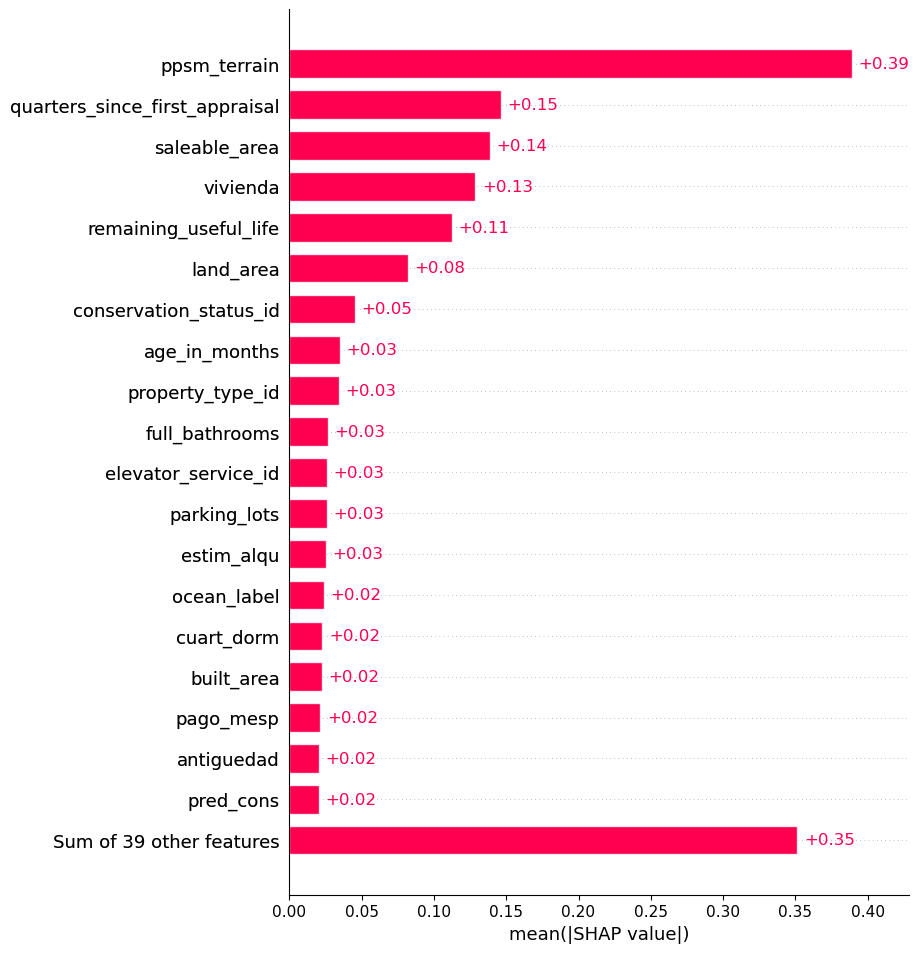

In [19]:
# plot feature importance
shap.plots.bar(shap_values, max_display=20)

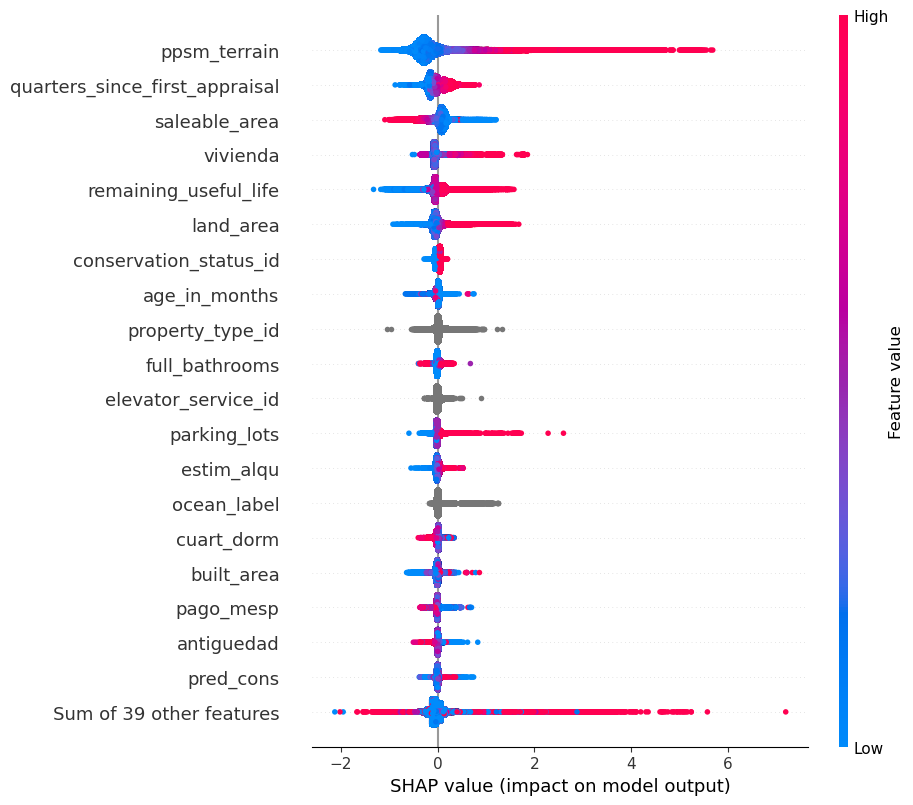

In [20]:
# Plot a beeswarm plot of SHAP values
shap.plots.beeswarm(shap_values, max_display=20)

---
# Sandbox

In [ ]:
df_properties.columns.to_list()

In [ ]:
df_properties.query("property_type_id.eq(4) & land_area.le(10)").describe()

In [ ]:
df_properties['property_type_id'].value_counts(normalize=True, dropna=False)

In [ ]:
df_properties['property_type_id']